In [1]:
import keras 
from utils import get_data, serialize_data, next_batch, breed_overview
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Set parameters

In [2]:
root_dir = "/home/anne/src/dog_identification/"  
train_zip = root_dir + "data/train.zip"
valid_zip = root_dir + "data/valid.zip"
training_filename = root_dir + "data/train.p"
validation_filename = root_dir + "data/valid.p"
labels_filename = root_dir + "data/labels.csv.zip"

num_validation = 0.3
batch_size = 250
n_batches = 50

n_breeds = 10

nwidth = 60
nheight = 60

### Inspect the data

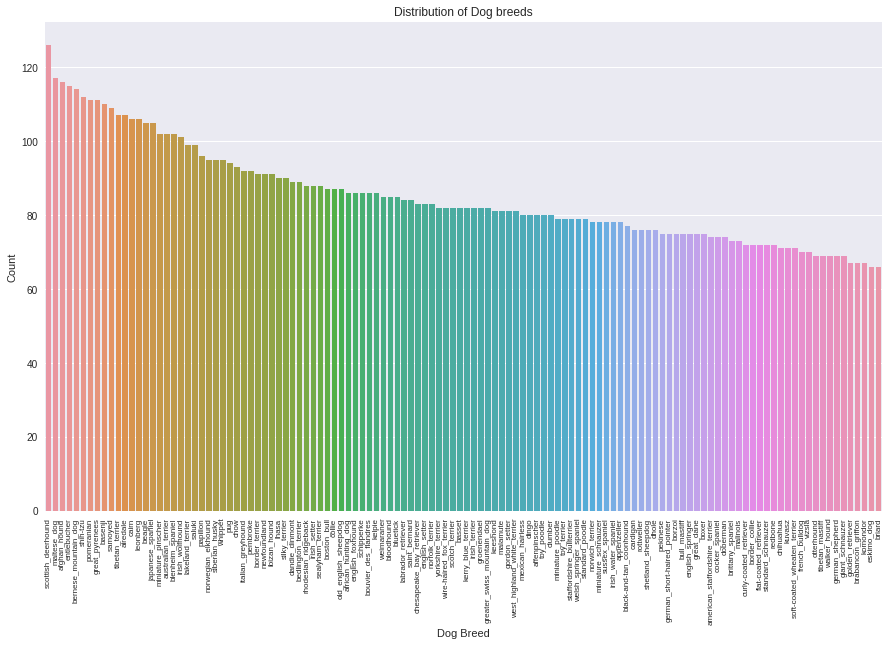

In [3]:
breed_overview(labels_filename)

### Process the data

In [4]:
# Load the whole dataset into memory
serialize_data(train_zip, labels_filename, training_filename, img_size=nwidth)
x, y, breed_dict = get_data(training_filename, labels_filename, top_breeds=n_breeds)

Creating serialized file format for /home/anne/src/dog_identification/data/train.zip
pickle file already exists, continueing
Loading pickle file /home/anne/src/dog_identification/data/train.p


In [5]:
y_hot = keras.utils.to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y_hot, test_size=num_validation, random_state=6)

# Eval train test sets
unique_train, freq_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
unique_val, freq_val = np.unique(np.argmax(y_val, axis=1), return_counts=True)

# Make sure every breed is included in both sets
assert (unique_train.shape[0]==unique_val.shape[0]), "Missing breeds in train/val sets"

print("Label frequency training set: max=%d, min=%d" % (np.amax(freq_train), np.amin(freq_train)))
print("Label frequency validation set: max=%d, min=%d" % (np.amax(freq_val), np.amin(freq_val)))

nb_train_samples = x_train.shape[0]
nb_val_samples = x_val.shape[0]

Label frequency training set: max=88, min=69
Label frequency validation set: max=42, min=25


### Create data flow objects

In [6]:
train_gen = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)
train_gen.fit(x_train)
train_flow = train_gen.flow(x_train, y_train, batch_size=batch_size)

val_gen = ImageDataGenerator()
val_gen.fit(x_val)
val_flow =val_gen.flow(x_val, y_val, batch_size=batch_size)

### Define the model

In [10]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(nwidth, nheight,3), data_format='channels_last'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_breeds, activation='softmax'))

print("Compiling model")
model.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adam(),
          metrics=['accuracy'])

model.summary()

Compiling model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 56, 56, 32)        2432      
_________________________________________________________________
activation_4 (Activation)    (None, 56, 56, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 64)        32832     
_________________________________________________________________
activation_5 (Activation)    (None, 25, 25, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 128)       73856

### Train the model

In [8]:
epochs = 20

print("Starting generator")
hist = model.fit_generator(
        train_flow,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=val_flow,
        validation_steps=nb_val_samples // batch_size)

Starting generator
Epoch 1/20
3/3 [==============================] - 3s 1s/step - loss: 2.3451 - acc: 0.0641 - val_loss: 2.3034 - val_acc: 0.1320
Epoch 2/20
3/3 [==============================] - 4s 1s/step - loss: 2.2987 - acc: 0.1027 - val_loss: 2.2834 - val_acc: 0.1120
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 2.2861 - acc: 0.1170 - val_loss: 2.2784 - val_acc: 0.1120
Epoch 4/20
3/3 [==============================] - 3s 1s/step - loss: 2.2802 - acc: 0.1144 - val_loss: 2.2528 - val_acc: 0.1320
Epoch 5/20
3/3 [==============================] - 3s 990ms/step - loss: 2.2463 - acc: 0.1629 - val_loss: 2.2136 - val_acc: 0.1840
Epoch 6/20
3/3 [==============================] - 4s 1s/step - loss: 2.2122 - acc: 0.1733 - val_loss: 2.1636 - val_acc: 0.2280
Epoch 7/20
3/3 [==============================] - 3s 1s/step - loss: 2.1451 - acc: 0.2296 - val_loss: 2.1166 - val_acc: 0.1800
Epoch 8/20
3/3 [==============================] - 3s 961ms/step - loss: 2.2103 - acc: 0.1

### Evaluate training

['acc', 'loss', 'val_acc', 'val_loss']


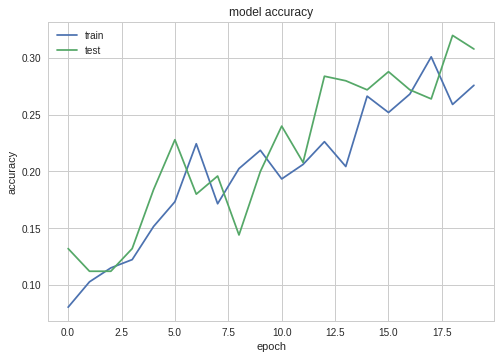

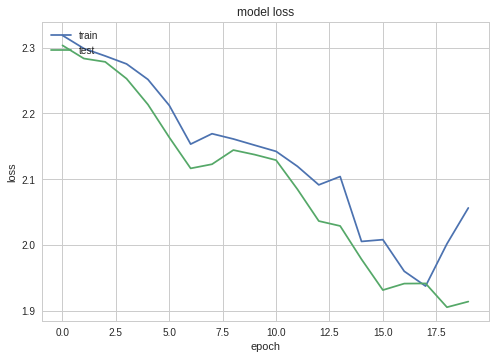

In [9]:
print(hist.history.keys())

# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(250, 56, 56, 32)


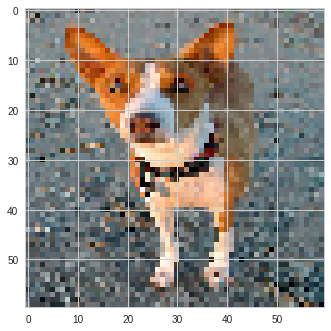

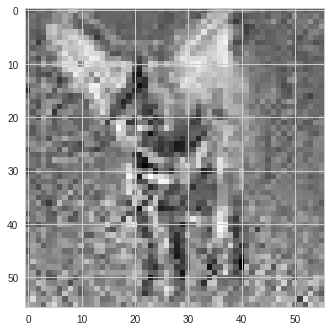

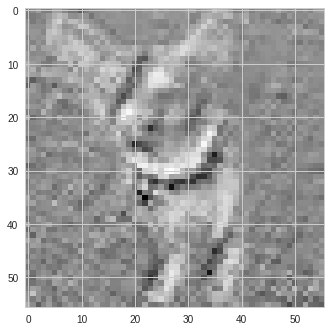

In [44]:
x_test, y_test = val_flow.next()


from keras import backend as K
conv0 = K.function([model.layers[0].input], [model.layers[0].output])
out0=conv0([x_test])[0]
print out0.shape

plt.imshow(x_test[0,:,:,:])
plt.show()
plt.imshow(out0[0,:,:,0])
plt.show()
plt.imshow(out0[0,:,:,31])
plt.show()

act0 = K.function([model.layers[1].input], [model.layers[1].output])
pool0 = K.function([model.layers[2].input], [model.layers[2].output])
